<link rel="shortcut icon" href="../assets/favicon.ico">

##  <a href="../index.html#relaciones_interprovinciales_en_espanha" style="color:grey;text-decoration: none"> &lt; &lt; Volver al Índice

----------------------------
<div style="text-align:center"><span style="color:green; font-family:Georgia; font-size:3em;"><u>Relaciones Interprovinciales en España</u></span></div>
    
--------------------------------------------

<div align="left"><a href="https://github.com/braisseara/blog"> <span style="color:green; font-family:Georgia; font-size:1em;"><u>Brais Seara Martínez @ github.com/braisseara/blog </u></span></a></div>

En esta entrada analizamos los datos de la **Estadística de Nacimientos** que elabora cada año el Instituto Nacional de Estadística (INE), prestando especial atención a las provincias de origen de los padres de los nacidos.

<a name="setup"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[I] Setup</span></div>

En este apartado cargamos todos los datos que vamos a usar 

# Descarga de los Ficheros de Nacimientos

Descargamos los ficheros de Nacimientos correspondientes a los años que queremos analizar, en la siguiente dirección del INE:

http://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177007&menu=resultados&secc=1254736195443&idp=1254735573002

Solamente nos descargamos los ficheros posteriores a 2007, porque los de años anteriores involucran metodologías heterogéneas.

En nuestro directorio de trabajo los almacenamos en la carpeta **../../datos/relaciones_interprovinciales_en_espanha**, separando por un lado los ficheros de **microdatos** propios de cada año, de los **metadatos** que vienen con cada uno de ellos, y que son iguales para todos. 

Tenemos además otra carpeta con todos los metadatos que hemos traído de otras fuentes, ubicada en **externos**

### Estructura de Carpetas de Datos

* ../../datos/relaciones_interprovinciales_en_espanha
    *    microdatos
        *        2007.txt
        *        2011.txt
        *        2014.txt
        *        2017.txt
    *    metadatos
        *        Diseñoanonimizadonacimientos.xls
        *        Valores válidosDiseñoanonimizadonacimientos.xls
        *        externos
            *            metadatos_provincias.txt
            *            pip_pc_provincia.txt
            *            pip_pp_ccaa.txt
        *    mapa

# Imports

In [1]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import math
from collections import Counter
# + tener mapclassify instalado

# Con esto conseguimos tener figuras de DataFrames uno al lado del otro y no debajo:
from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

Con esto conseguimos que las imagenes se muestren completas sin scrollbar:

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Config

In [3]:
colormap = "Reds" #"seismic" #"OrRd"

# Metadatos

### INE.Nacimientos

El INE nos proporciona 2 ficheros excel de metadatos para los Nacimientos a partir del 2007:
* *Diseñoanonimizadonacimientos.xls*

* *Valores válidosDiseñoanonimizadonacimientos.xls*

Lo único que ahora nos interesa de ellos son 3 columnas del primero, que nos indican la Longitud fija que ocupan los registros de cada columna de microdatos, sus Nombres, y la Descripción de lo que representan.

In [4]:
ruta_datos = "../../datos/relaciones_interprovinciales_en_espanha/"

In [5]:
metadatos_ine = pandas.read_excel(ruta_datos + "metadatos/Diseñoanonimizadonacimientos.xls", 0)
metadatos_ine = metadatos_ine[['Longitud','Nombre','Descripción']]

In [6]:
metadatos_ine.head()

Longitud  Nombre               Descripción
0         2    PROI  PROVINCIA DE INSCRIPCIÓN
1         3    MUNI  MUNICIPIO DE INSCRIPCIÓN
2         2  MESPAR            MES DEL PARTO 
3         4  ANOPAR             AÑO DEL PARTO
4         2  PROPAR      PROVINCIA DEL PARTO

### Externos

Los metadatos que nos proporciona el INE en los mismos ficheros de Nacimientos son insuficientes, ya que las provincias están representadas según un código numérico, por lo que necesitamos un mapping que nos dé los nombres reales de las provincias. El mapping lo podemos encontrar aquí:

https://www.ine.es/daco/daco42/codmun/cod_provincia.htm

Además, también nos interesa otra información sobre las provincias con el fin de poder agruparlas u ordenarlas de algún modo significativo.

En el archivo  **/despues_2007/metadatos/externos/metadatos_provincias.txt** adjuntamos la CCAA autónoma, y también los gentilicios masculino y femenino.

A partir de las estadísticas económicas del INE, obtenemos el PIB per Cápita de cada provincia y de cada Comunidad Autónoma

https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736167628&menu=resultados&idp=1254735576581

que guardamos en los ficheros **/despues_2007/metadatos/externos/pip_pc_provincia.txt** y         **/despues_2007/metadatos/externos/pip_pc_ccaa.txt**

In [7]:
metadatos_provincias = pandas.read_csv(ruta_datos + "metadatos/externos/metadatos_provincias.txt", '\t', encoding = 'iso8859_3')

pip_pc_provincia = pandas.read_csv(ruta_datos + "metadatos/externos/pip_pc_provincia.txt", '\t', encoding = 'iso8859_3')
pip_pp_ccaa = pandas.read_csv(ruta_datos + "metadatos/externos/pip_pp_ccaa.txt", '\t', encoding = 'iso8859_3')

metadatos_provincias = metadatos_provincias.join(pip_pc_provincia.set_index('Provincia'), how = 'left', on = 'Provincia')
metadatos_provincias = metadatos_provincias.join(pip_pp_ccaa.set_index('CCAA'), on = 'CCAA', how = 'left')

metadatos_provincias.set_index('Provincia').sort_values('pip_pc', ascending = False).head()

Código        CCAA      gen_mas      gen_fem  nortesur  pip_pc  \
Provincia                                                                   
Araba           1  País Vasco       alavés      alavesa         8   36066   
Madrid         28      Madrid    madrileño    madrileña        28   32857   
Gipuzcoa       20  País Vasco  guipuzcoano  guipuzcoana         6   31486   
Bizkaia        48  País Vasco     bizcaíno     bizcaína         5   30378   
Navarra        31     Navarra      navarro      navarra         9   29859   

            pop  pip_pc_ccaa  
Provincia                     
Araba       323        32969  
Madrid     6446        33824  
Gipuzcoa    708        32969  
Bizkaia    1134        32969  
Navarra     638        30853

Creamos diccionarios que nos permitan acceder a algunos de estos metadatos facilmente:

In [8]:
dict_cod_prov  = {provincia[1]: provincia[2] for provincia in metadatos_provincias.itertuples()}
dict_prov_ccaa = {provincia[2]: provincia[3] for provincia in metadatos_provincias.itertuples()}
dict_gen_mas   = {provincia[2]: provincia[4] for provincia in metadatos_provincias.itertuples()}
dict_gen_fem   = {provincia[2]: provincia[5] for provincia in metadatos_provincias.itertuples()}

# Mapa

Cargamos el mapa de España en formato *shape* que usaremos más adelante

In [9]:
map_df = gpd.read_file(ruta_datos + "shape_map_spain/Provincias_ETRS89_30N.shp")
map_df.index = map_df["Texto_Alt"]

# Provincias Agrupadas y Ordenadas

Con estos datos podemos crear una lista ordenada de Provincias, agrupadas por CCAA, ordenadas las CCAA por PIB per Cápita, y ordenadas también por PIB per Cápita las provincia dentro de su CCAA:

In [10]:
provincias_ordenadas = metadatos_provincias.sort_values(['pip_pc_ccaa','pip_pc'], ascending = False)['Provincia']
#provincias_ordenadas = metadatos_provincias.sort_values(['nortesur'], ascending = True)['Provincia']

provincias_ordenadas[0:10]

27       Madrid
7         Araba
5      Gipuzcoa
4       Bizkaia
8       Navarra
22    Tarragona
21    Barcelona
15       Girona
20       Lleida
13       Huesca
Name: Provincia, dtype: object

In [11]:
dict_provincias_ordenadas = {provincia[2]: provincia[0] for provincia in provincias_ordenadas.reset_index().itertuples()}

provincia_Muestra = "Barcelona"
print(provincia_Muestra + ' va de ' + str(dict_provincias_ordenadas[provincia_Muestra]+1) + 'ª')

Barcelona va de 7ª


# Lectura Microdatos

In [12]:
años = [2017]

ruta_microdatos = ruta_datos + "microdatos/"

if not "DFs_" in vars():
    DFs_ = {}
DFs  = {}
for año in años:  
    try:
        DFs[año] = DFs_[año].copy()
    except KeyError:
        DFs_[año] = pandas.read_fwf(ruta_microdatos + str(año) + ".txt", widths= metadatos_ine['Longitud'])
        DFs[año] = DFs_[año].copy()

In [13]:
for key in list(DFs.keys()):
    # nombramos columnas
    DFs[key].columns = metadatos_ine['Nombre']
    # nos quedamos con las columnas que nos interesan
    DFs[key] =  DFs[key][['PROMA','PROPA','PROI']]  # prov. nacimiento madre, prov. nacimiento padre y prov. nacimiento niñ@
    # eliminamos filas con valores nulos
    DFs[key] =  DFs[key][np.isfinite( DFs[key]['PROI'])]
    DFs[key] =  DFs[key][np.isfinite( DFs[key]['PROMA'])]
    DFs[key] =  DFs[key][np.isfinite( DFs[key]['PROPA'])]
    # eliminamos filas correspondientes a padres y madres nacidos en el extranjero
    DFs[key] =  DFs[key][DFs[key]['PROMA'] != 99]      
    DFs[key] =  DFs[key][DFs[key]['PROPA'] != 99]
    # substituímos los códigos de las provincias por sus nombres 
    DFs[key] = DFs[key].replace({'PROI':dict_cod_prov})
    DFs[key] = DFs[key].replace({'PROMA':dict_cod_prov})
    DFs[key] = DFs[key].replace({'PROPA':dict_cod_prov})

In [14]:
DFs[año].head().reset_index(drop = True)

Nombre      PROMA      PROPA       PROI
0          Madrid   A Coruña   A Coruña
1          Madrid       León     Madrid
2          Madrid     Madrid     Madrid
3       Barcelona  Barcelona  Barcelona
4       Barcelona  Barcelona  Barcelona

In [15]:
print(' Toda la información que contienen nuestros DataSets es tipo: \n')

for row in DFs[año].head().reset_index(drop = True).itertuples():
    print(str(row[0] + 1) + '- una ' + dict_gen_fem[row[1]] + " y un " + dict_gen_mas[row[2]] + " son padres en " + row[3])
print ('...\n\n' + '(' + str(DFs[año].shape[0]) + ' nacimientos en total, año ' + str(año) + ')')

 Toda la información que contienen nuestros DataSets es tipo: 

1- una madrileña y un coruñés son padres en A Coruña
2- una madrileña y un leonés son padres en Madrid
3- una madrileña y un madrileño son padres en Madrid
4- una barcelonesa y un barcelonés son padres en Barcelona
5- una barcelonesa y un barcelonés son padres en Barcelona
...

(269178 nacimientos en total, año 2017)


<a name="conteo"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[II] Conteo Nacidos por Provincia de Origen de los Padres</span></div>

A continuación, procedemos a elaborar una matriz que recoja el número de nacidos para cada combinación de origines provinciales de los padres

In [16]:
def get_matrices(provincia = 'todas', minimo_hijos = 0):
    
    matrices = {}

    for key in list(DFs.keys()):
        
        # crear matriz de ceros
        matrices[key] = []
        for i in range(0,len(provincias_ordenadas)):
            matrices[key].append([])
            for j in range(0,len(provincias_ordenadas)):
                matrices[key][i].append(0)
                
        # rellenar matriz
        for nac in DFs[key].itertuples():
            try:
                if provincia != 'todas':
                    if nac[3] == provincia:
                        matrices[key][dict_provincias_ordenadas[nac[1]]][dict_provincias_ordenadas[nac[2]]] += 1
                else:
                    matrices[key][dict_provincias_ordenadas[nac[1]]][dict_provincias_ordenadas[nac[2]]] += 1
            except KeyError:
                continue
            
        # etiquetar matriz
        matrices[key] = pandas.DataFrame(matrices[key])
        matrices[key].columns= provincias_ordenadas
        matrices[key].index = provincias_ordenadas
        
    for key in list(DFs.keys()): 
        
        # restringir matriz
        booleanos = list((matrices[key].sum(1) + matrices[key].sum(0))/2 > minimo_hijos)
        provincias_significativas = pandas.Series(list(matrices[key].index)).loc[booleanos]
        matrices[key] = matrices[key].loc[provincias_significativas, provincias_significativas]
        
    return(matrices)

In [17]:
matrices = get_matrices()

Dado que existen grandes diferencias en el número de nacidos con cada combinación de provincias de los padres, al haber provincias con poblaciones mucho mayores que otras, podemos considerar aplicar a las matrices creadas una función de suavizado logarítmico

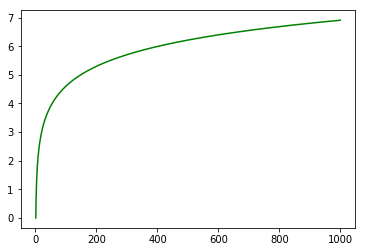

In [18]:
a = np.arange(1,1000,1)
b = [math.log(i) for i in a ]
_ = plt.plot(a, b, color = "g")

Ilustración del efecto suavizador que produce la función logarítmica

### Función de representación gráfica de matrices:
(con opción de suavizado logarítmico)

In [19]:
def plot_matriz(matriz, titulo = 'Matriz', suavizado_logaritmico = False, times_sl = 1, anular_diagonal = False):
    matriz = matriz.copy()
    provincias = list(matriz.index)
    n = len(provincias)
    if anular_diagonal == True:
        for i in range(0,n):
            matriz.iloc[i,i] = min(matriz.min())
    if suavizado_logaritmico == True:
        for time in range(0,times_sl):
            matriz = matriz.applymap(lambda celda : math.log(max(0,celda) + 1) )
    fig, ax = plt.subplots(1, figsize=(13, 13))
    plt.imshow(matriz, cmap = colormap, aspect='auto')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(provincias)
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(provincias, rotation=70)
    ax.set_title(titulo, fontdict = {'fontsize': 30,'fontweight':500}, pad =30)
    ax.set_xlabel('padre',fontweight='bold',fontsize=20, labelpad = 10)
    ax.set_ylabel('madre',fontweight='bold',fontsize=20, labelpad = 10)

    ps = pandas.Series(provincias).reset_index()
    ps.columns = ['i', 'Provincia']
    ccaa_n = ps.join(metadatos_provincias.set_index('Provincia'), how = 'left', on = 'Provincia')['CCAA']
    ccaa_n = list(pandas.DataFrame.from_dict(Counter(ccaa_n), orient='index').iloc[:,0].cumsum().apply(lambda i: i-0.5))

    ax.set_yticks(ccaa_n, minor = True)
    ax.set_xticks(ccaa_n, minor = True)
    ax.grid(which='minor', alpha=1, linewidth = 1.2, linestyle=':', color = 'black')

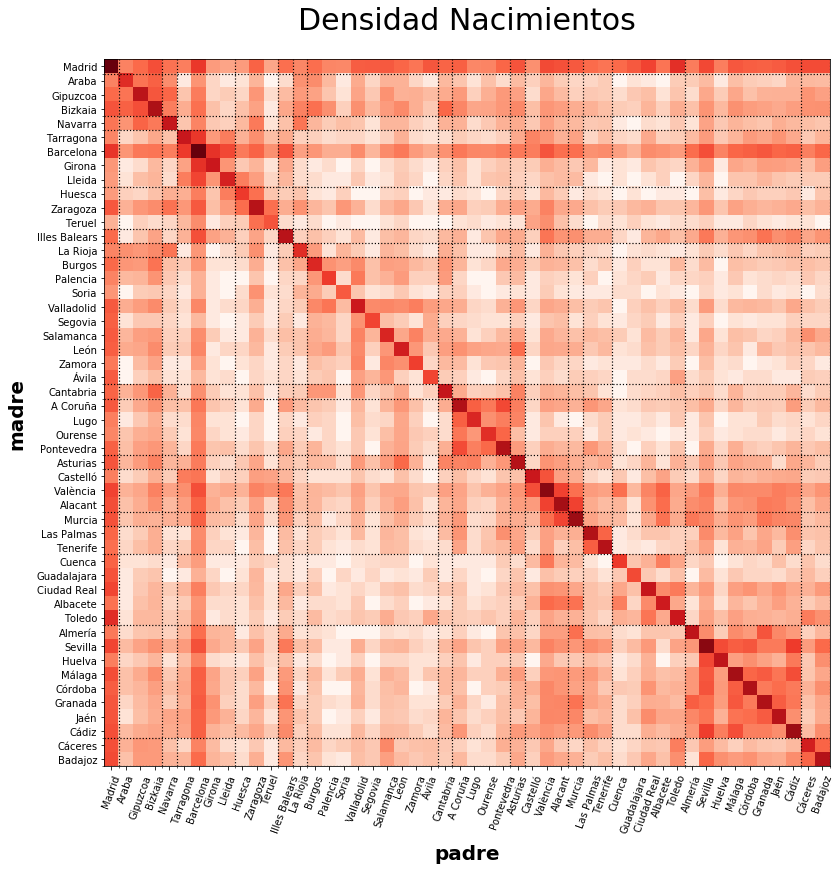

In [20]:
plot_matriz(matrices[año], "Densidad Nacimientos", True)

En este gráfico suavizado, donde agrupamos las provincias por CCAA, podemos visualizar la mayor frecuencia de nacidos de padres procedentes de la misma provincia (línea oscura diagonal), y también de nacidos con padres procedentes de la misma Comunidad Autónoma (cuadrados rodeados de lineas discontinuas centrados en la diagonal). Asímismo, podemos ver que los procedentes de las provincias de Madrid y Barcelona engendran una cantidad no despreciable de hijos con personas procedents de prácticamente cualquier otra de las provincias de España

Vamos a crear una función para obtener facilmente las primeras (o ultimas) posiciones del ranking en matrices de este tipo

### Función de Rankings:

In [21]:
def top_matriz(matriz, top = 10, que = 'max', x = 'values', madres=None, padres=None, funcion_values=lambda x:round(x, 2),c=''):
    madre = []
    padre = []
    values = []
    if madres == None:
        madres = list(matriz.columns)
    else:
        if isinstance(madres, str):
            madres = [madres]
    if padres == None:
        padres = list(matriz.columns)
    else:
        if isinstance(padres, str):
            padres = [padres]
    for i in madres:
        for j in padres:
            madre.append(i) 
            padre.append(j) 
            values.append(matriz.loc[i,j])
    df = pandas.DataFrame({'madre': madre, 'padre': padre, x: values}).sort_values([x], ascending = (que == 'min') )
    df.index = [str(i + 1) + 'º' for i in df.reset_index().index]
    if isinstance(funcion_values, str):
        if funcion_values == 'delta%':
            funcion_values = lambda x : '+ ' + str(round((x-1)*100,2)) + ' %'
        elif funcion_values == 'delta':
            funcion_values = lambda x : '+ ' + str(round(x,2))
        elif funcion_values == '%':
            funcion_values = lambda x : str(round(x*100,2)) + ' %'
    df[x] = df[x].apply(funcion_values)
    if isinstance(top, str):
        top = matriz.shape[0]
    return(df.head(top).style.set_caption(c))

In [22]:
top_matriz(matrices[año], x = 'nacimientos', c = 'Provincias con más hijos')

<a name="sexos"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[III] Vizcaínas, Zaragozanos y Viceversa </span></div>

En este apartado estudiamos la posibilidad de que, por ejemplo, existan más Vizcaínas teniendo hijos con Zaragozanos que Vizcaínos teniendo hijos con Zaragozanas

In [23]:
matriz_sexo_diferencial = matrices[año].copy()
n = matrices[año].shape[0]
umbral = n/2
for i in range(0,n):
    for j in range(0,n):
        matriz_sexo_diferencial.iloc[i,j] =  matrices[año].iloc[j,i] - matrices[año].iloc[i,j]

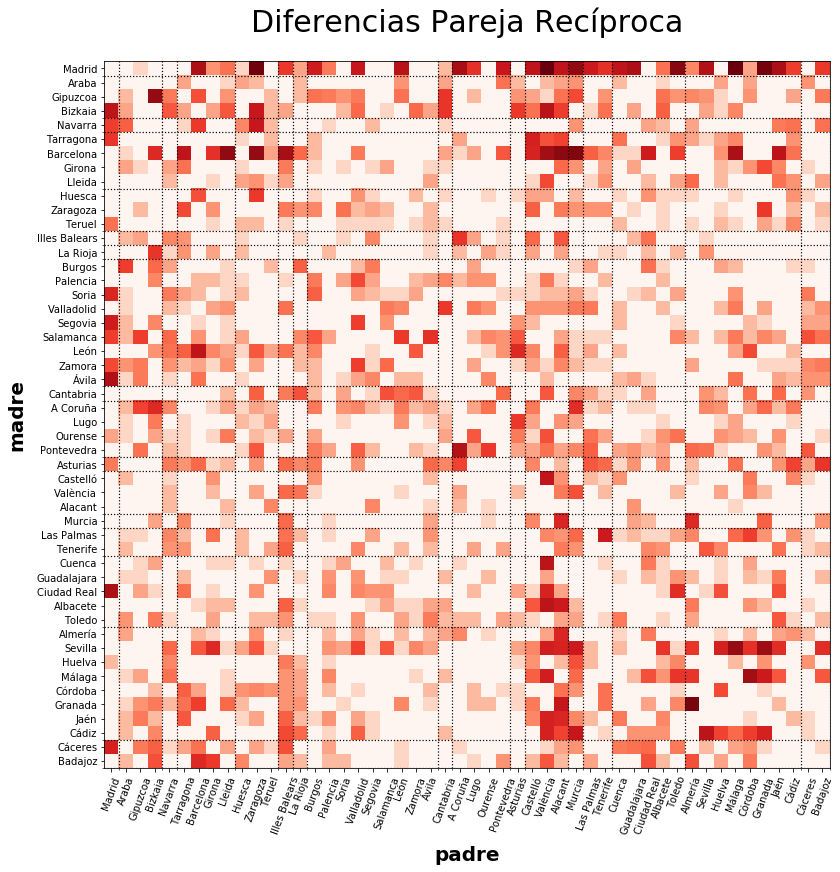

In [24]:
plot_matriz(matriz_sexo_diferencial, 'Diferencias Pareja Recíproca', True)

En esta matriz la intensidad del color rojo indica que esa pareja es más frecuente que su recíproca. Por ejemplo, vemos que en general son más frecuentes las parejas reproductivas de Madrileñas con gente de otras provincias que de Madrileños con gente de otras provincias. Asímismo, vemos que en general los Valencianos tienen más éxito con las Andaluzas que las Valencianas con los Andaluces.

In [25]:
matriz_sexo_diferencial = matrices[año].copy()
n = matrices[año].shape[0]
minimo_significativo = 20
for i in range(0,n):
    for j in range(0,n):
        if matrices[año].iloc[i,j] > minimo_significativo and matrices[año].iloc[j,i] > minimo_significativo:
            matriz_sexo_diferencial.iloc[i,j] = max(matrices[año].iloc[j,i] / matrices[año].iloc[i,j], 1)
        else:
            matriz_sexo_diferencial.iloc[i,j] = 1

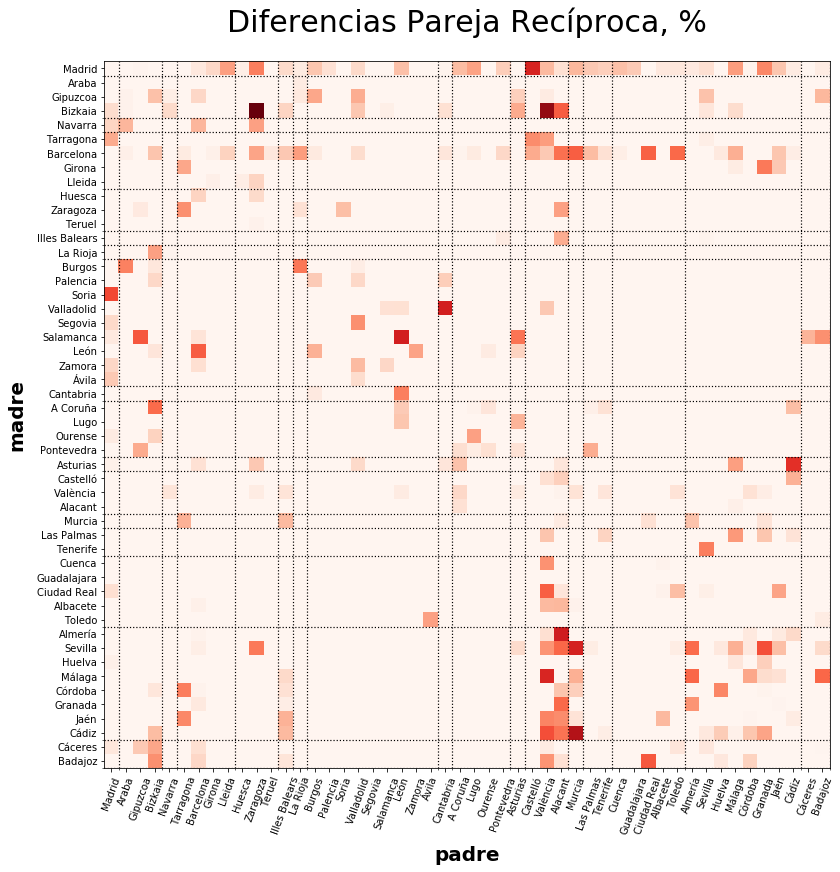

In [26]:
plot_matriz(matriz_sexo_diferencial, 'Diferencias Pareja Recíproca, %', True)

Esta matriz es equivalente a la anterior, solo que la frecuencia de una pareja reproductiva respecto a su recíproca provincial se expresa en términos porcentuales, por lo que ahora podemos comparar estas anomalías entre diferentes provincias sin importarnos el peso poblacional de cada una

In [27]:
top_matriz(matriz_sexo_diferencial, x = 'respecto a viceversa', funcion_values = 'delta%')

En este ranking vemos que, curiosamente, las dos mayores desviaciones las protagonizan las Vizcaínas. Hay el doble de Vizcaínas teniendo hijos con Zaragozanos que al revés, y con Valencianos, un 90% más.

In [28]:
top_matriz(matriz_sexo_diferencial, top = 3, x = 'respecto a viceversa', madres = 'Ourense', funcion_values = 'delta%')

Analizando el caso de Ourense, vemos a donde han podido ir a buscar parejas reproductivas algunos de esos Vizcaínos que han visto a sus mujeres irse con Zaragozanos y Valencianos.

In [29]:
top_matriz(matriz_sexo_diferencial, top = 3, x = 'respecto a viceversa', padres = 'Ourense', funcion_values = 'delta%')

<a name="fidelidad"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[IV] Fidelidad Provincial</span></div>

### Normalización Matriz por Pareja

In [30]:
def get_matrices_pareja_normal(matrices):
    
    matrices_pareja_normal = {}
    
    for key in list(DFs.keys()):
            
        # normalizar matriz por pareja
        matrices_pareja_normal[key] = matrices[key].astype('float64')
        for i in matrices[key].index:
            total_mujeres = matrices[key].loc[i,:].sum()
            for j in matrices[key].columns:
                total_hombres = matrices[key].loc[:,j].sum()
                resto = total_hombres - total_mujeres
                hijos_potenciales = (total_mujeres+total_hombres-resto)/2
                matrices_pareja_normal[key].loc[i,j]=matrices[key].loc[i,j]/hijos_potenciales
                
    return(matrices_pareja_normal)

In [31]:
matrices_pareja_normal = get_matrices_pareja_normal(matrices)

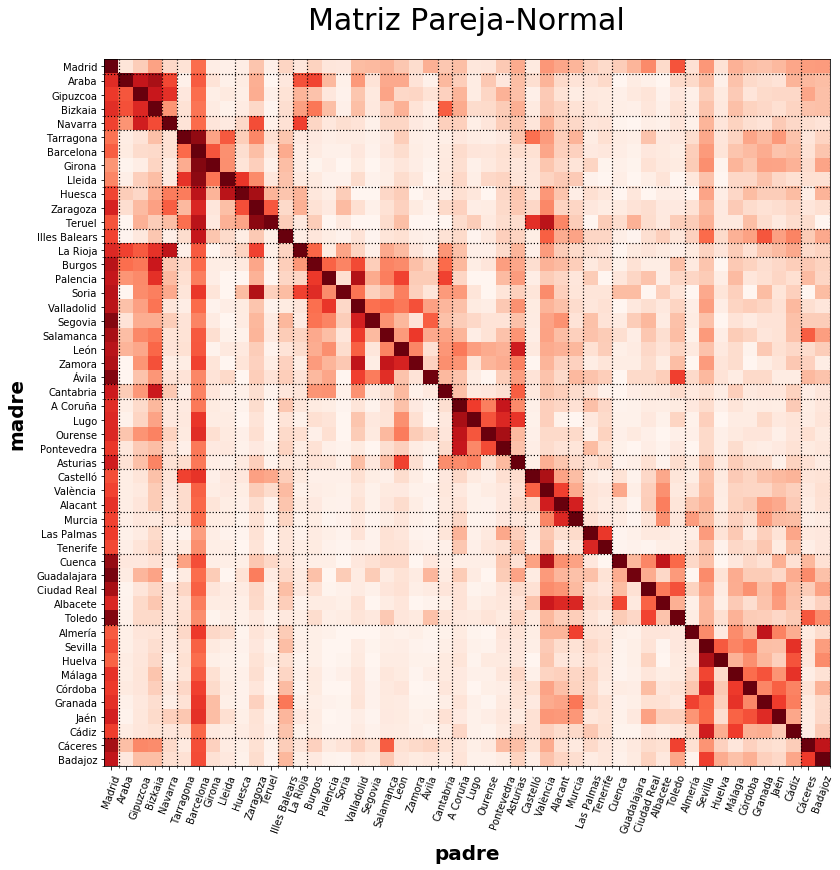

In [32]:
plot_matriz(matrices_pareja_normal[año], 'Matriz Pareja-Normal', True, 100, False)

En esta matriz representamos el número de niños para cada combinacion provincial de padres y madres, en relación al número de hijos que tendrían si todos naciesen de esa combinación (nótese que hemos aplicado 100 veces el suavizado logarítmico, ya que sin esta transformación prácticamente solo veríamos coloreada la diagonal)

In [33]:
def get_diagonal(matriz, ordenar = True):
    diagonal = []
    for i in range(0,matriz.shape[0]):
        diagonal.append(matriz.iloc[i,i])
    diagonal = pandas.Series(diagonal,list(matriz.index))
    if ordenar == True:
        diagonal = diagonal.sort_values(ascending = False)
    return(diagonal)

In [34]:
def top_serie(serie, top = 10, que = 'max', x = 'values', funcion_values = lambda x : round(x, 2), c = ''):
    df = pandas.DataFrame({'Provincia': serie.index , x: serie}).sort_values([x], ascending = (que == 'min'))
    df.index = [str(i + 1) + 'º' for i in df.reset_index().index]
    if isinstance(funcion_values, str):
        if funcion_values == 'delta%':
            funcion_values = lambda x : '+ ' + str(round((x-1)*100,2)) + ' %'
        elif funcion_values == 'delta':
            funcion_values = lambda x : '+ ' + str(round(x,2))
        elif funcion_values == '%':
            funcion_values = lambda x : str(round(x*100,2)) + ' %'
    df[x] = df[x].apply(funcion_values)
    df.name= "frre"
    return(df.head(top).style.set_caption(c))

In [35]:
fidelidad = get_diagonal(matrices_pareja_normal[año])
display(top_serie(fidelidad, x = 'Fidelidad', funcion_values = '%', c = 'Top 10 mayor Fidelidad Provincial'))
display(top_serie(fidelidad, que = 'min', x = 'Fidelidad', funcion_values = '%', c = 'Top 10 menor Fidelidad Provincial'))

Mayores y menores porcentajes de hijos entre personas de la misma provincia.

Los más "fieles" a su provincia a la hora de elegir padre/madre para sus hijos son las gentes de las dos provincias Canarias, algo lógico dado su relativo aislamiento geográfico. En cambio, la provincia más fiel de la Península es Murcia.

El top 3 de las provincias más "infieles" en este sentido lo encabezan Guadalajara, Teruel y Ávila.

In [36]:
def plot_mapa(serie, titulo = ' ', suavizado_logarítmico = False, times_sl = 1):
    if suavizado_logarítmico == True:
        for time in range(0,times_sl):
            serie = serie.apply(lambda celda : math.log(max(0,celda) + 1) )    
    serie.name = titulo
    mapa = map_df.join(serie)
    mapa.loc[mapa[titulo].isnull(),titulo]  = 0
    mapa = mapa[mapa["CCAA"] != "Canarias"]
    
    fig, ax = plt.subplots(1,1, figsize=(20, 20), squeeze =True)
    eq = 'fisher_jenks'
    mapa.plot(column=titulo,cmap=colormap,linewidth=1.8,ax=ax,k=10,edgecolor='0.2', scheme= eq, legend=True)
    ax.set_title(titulo, fontdict = {'fontsize': 30,'fontweight':700}, pad =30)
    ax.axis('off')

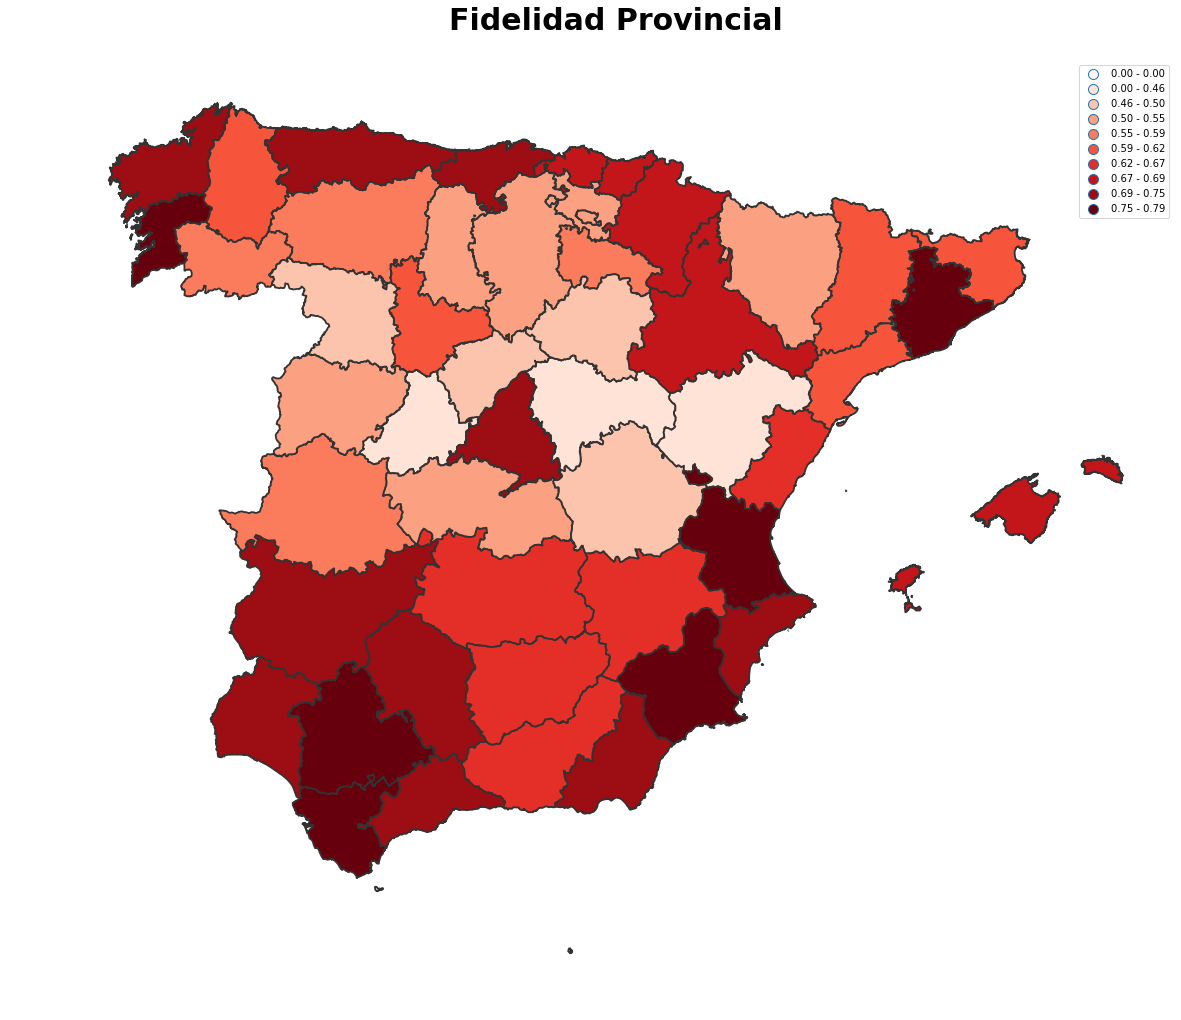

In [63]:
_ = plot_mapa(fidelidad, 'Fidelidad Provincial')

En este mapa representamos el porcentaje de niños que nacen con ambos padres de cada provincia, en relación a los que podrían llegar a nacer si todos se reprodujesen intraprovincialmente

<a name="reparto"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[V] La Exogamia de la España Interior </span></div>

En el apartado anterior vimos que menos de la mitad de la gente que tiene un hijo con alguien de Guadalajara es de Guadalajara también.

¿Con quienes tienen hijos los guadalajareños y las guadalajareñas? ¿y la gente de otras provincia?

En este aparatado vamos a analizarlo.

In [38]:
def get_matrices_madre_normal(matrices):
    
    matrices_madre_normal = {}
    
    for key in list(DFs.keys()):
    
        # normalizar matriz por madre
        matrices_madre_normal[key] = matrices[key].astype('float64')
        for i in matrices[key].index:
            total = matrices[key].loc[i,:].sum()
            for j in matrices[key].columns:
                matrices_madre_normal[key].loc[i,j] = matrices[key].loc[i,j]/total
              
    return(matrices_madre_normal)

def get_matrices_padre_normal(matrices):
    
    matrices_padre_normal = {}
    
    for key in list(DFs.keys()):
            
        # normalizar matriz por padre
        matrices_padre_normal[key] = matrices[key].astype('float64')
        for j in matrices[key].columns:
            total = matrices[key].loc[:,j].sum()
            for i in matrices[key].index:
                matrices_padre_normal[key].loc[i,j] = matrices[key].loc[i,j]/total
                
    return(matrices_padre_normal)

In [39]:
matrices_madre_normal = get_matrices_madre_normal(matrices)
matrices_padre_normal = get_matrices_padre_normal(matrices)

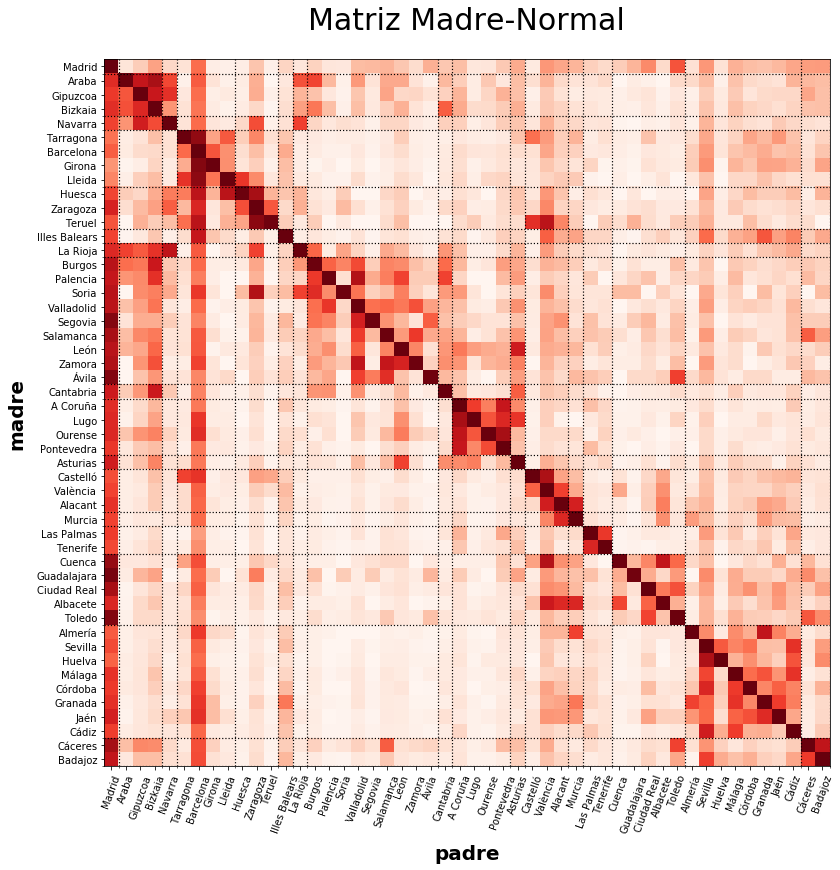

In [40]:
plot_matriz(matrices_madre_normal[año], 'Matriz Madre-Normal', True, 100, False)

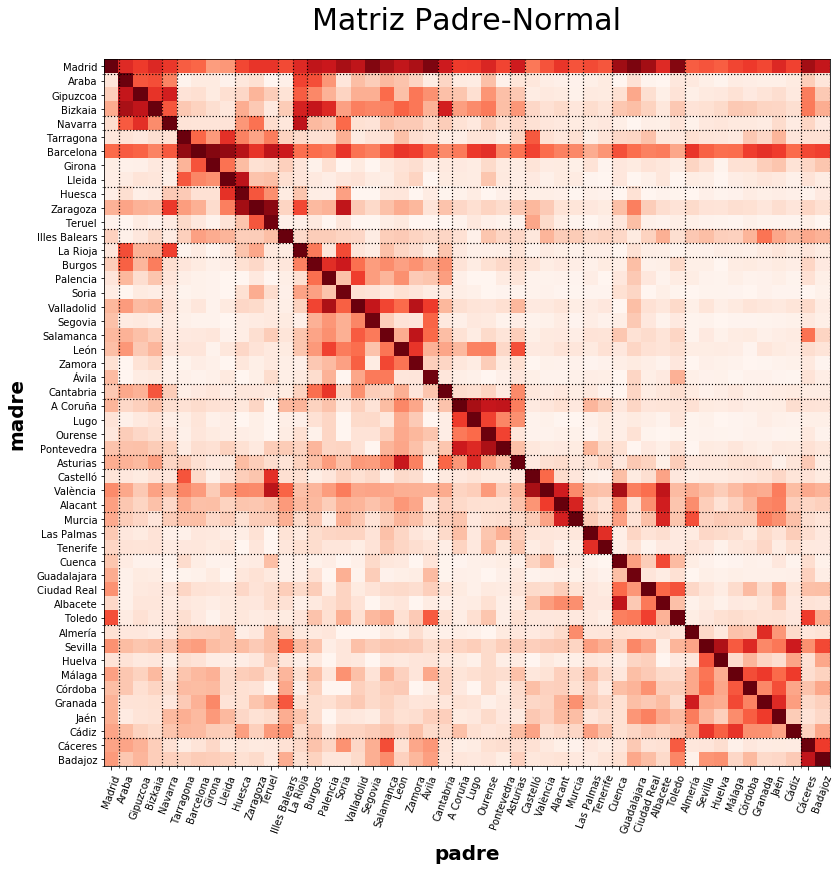

In [41]:
plot_matriz(matrices_padre_normal[año], 'Matriz Padre-Normal', True, 100, False)

In [42]:
c = 'Porcentaje de hijos que los guadalajareños tienen con mujeres de Guadalajara y de otras Provincias'
guadalajareños = top_matriz(matrices_padre_normal[año], x = '%', padres = 'Guadalajara', funcion_values  = '%', c = c )
display(guadalajareños)
c = 'Porcentaje de hijos que las guadalajareñas tienen con hombres de Guadalajara y de otras Provincias'
guadalajareñas = top_matriz(matrices_madre_normal[año], x = '%', madres = 'Guadalajara', funcion_values  = '%', c = c )
display(guadalajareñas)

In [43]:
def plot_filas(filas, labels, titulo = '', sl = False, tsl = 1):
    m = len(filas)
    prov = list(filas[0].index)
    if len(prov) == 1:
        prov = list(filas[0].transpose().index)
    n = len(prov)
    
    fig, ax = plt.subplots(m, 1, figsize=(30, 2), squeeze =True)
    
    ax[0].set_title(titulo, fontdict = {'fontsize': 30,'fontweight':700}, pad =30)
    
    for i in range(0,m):
        if sl == True:
            for time in range(0,tsl):
                filas[i] = filas[i].applymap(lambda celda : math.log(max(0,celda) + 1))
        _ = ax[i].set_yticklabels([])
        _ = ax[i].imshow(filas[i], aspect='auto',  cmap = "Reds")
        _ = ax[i].set_xticks(np.arange(n))
        _ = ax[i].set_ylabel(labels[i],fontweight=1000,fontsize=50, labelpad = 30, rotation = 0)
        if i == m - 1:
            _ = ax[i].set_xticklabels(prov, rotation=80, fontdict = {'fontsize': 20,'fontweight':700})
        else:
            _ = ax[i].set_xticklabels([])

In [44]:
def plot_sexos_prov(provincia,en='',sl=True,tsl=100):
    fila_madre = matrices_madre_normal[año].loc[[provincia]]
    fila_padre = matrices_padre_normal[año].transpose().loc[[provincia]]
    if en != '':
        en = ' en ' + en + ' '
    tit = 'Parejas Reproductivas de las mujeres y los hombres de '+ provincia + en + ', por provincia'
    plot_filas([fila_madre,fila_padre],['♀','♂'],tit,sl,tsl)

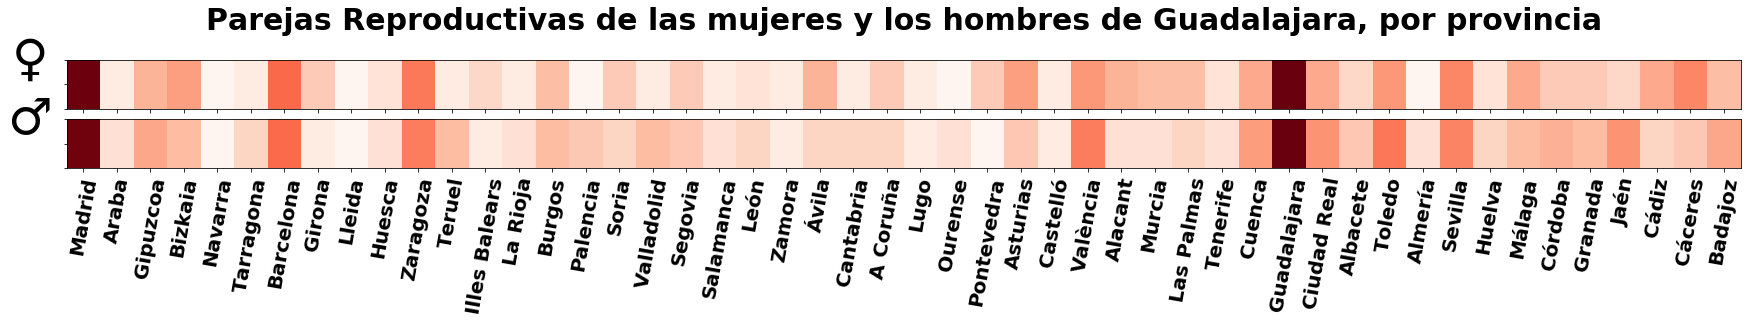

In [45]:
plot_sexos_prov('Guadalajara')

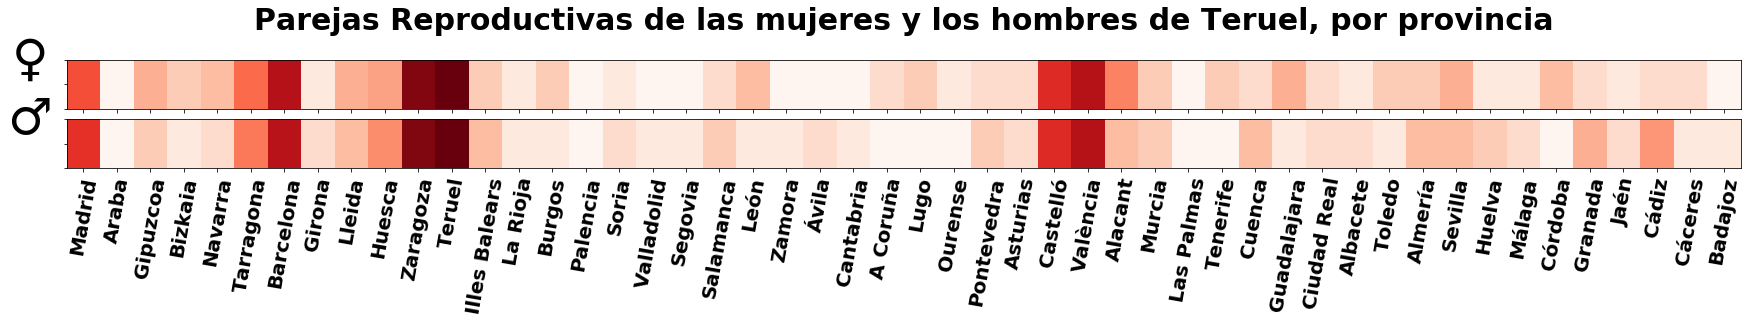

In [46]:
plot_sexos_prov('Teruel')

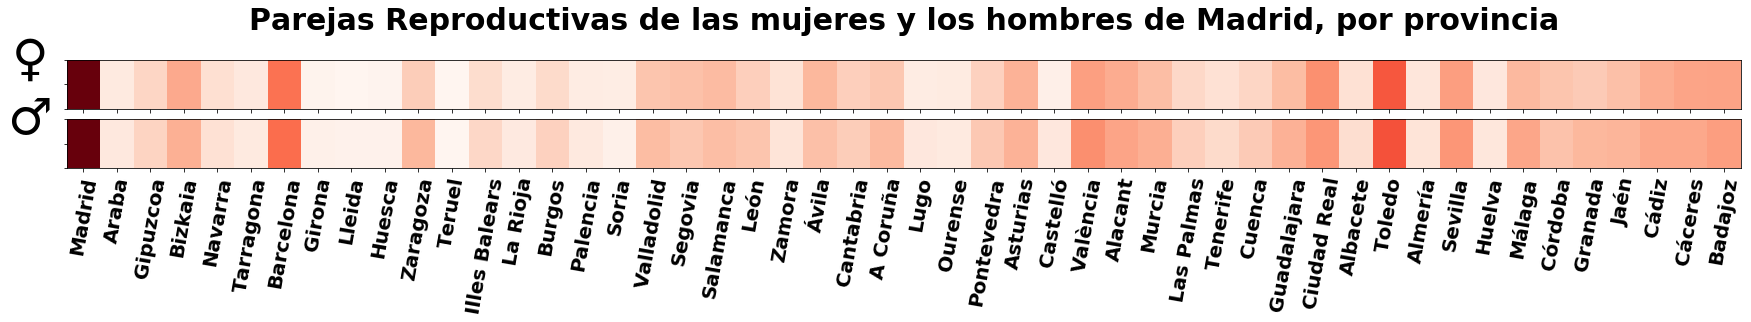

In [47]:
plot_sexos_prov('Madrid')

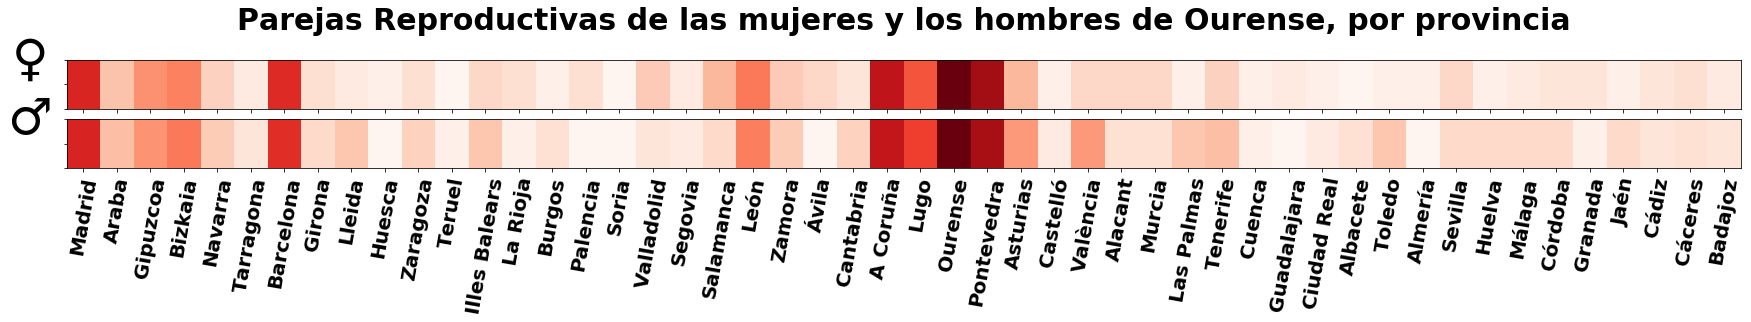

In [48]:
plot_sexos_prov('Ourense')

<a name="donde"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[VI] Provincianos en Madrid y Barcelona</span></div>

En los DataFrames de Nacimientos habíamos cargado una columna de información que aún no hemos usado, que es la provincia de inscripción de los nacidos. Hemos preferido esta columna a la del lugar de nacimiento, que también existe, porque seguramente estará más completa.

En este apartado usamos esta información para intentar hacernos una idea de las parejas reproductivas de los habitantes de las provincias cuando emigran a Madrid o Barcelona.

No podemos saber si la madre Navarra y el padre Ourensano de un niño nacido en Barcelona se conocieron en Navarra, Ourense, o Barcelona, pero al tratarse esta última de la población más grande y que recibe más migración interior, a efectos estadísticos podemos suponer se conocieron en Barcelona para darle un sentido a este apartado, aunque los datos podrían interpretarse de otra manera.

### A Barcelona

In [49]:
matrices_barcelona = get_matrices('Barcelona')
matrices_pareja_normal = get_matrices_pareja_normal(matrices_barcelona)
matrices_padre_normal = get_matrices_padre_normal(matrices_barcelona)
matrices_madre_normal = get_matrices_madre_normal(matrices_barcelona)

#### de Lleida

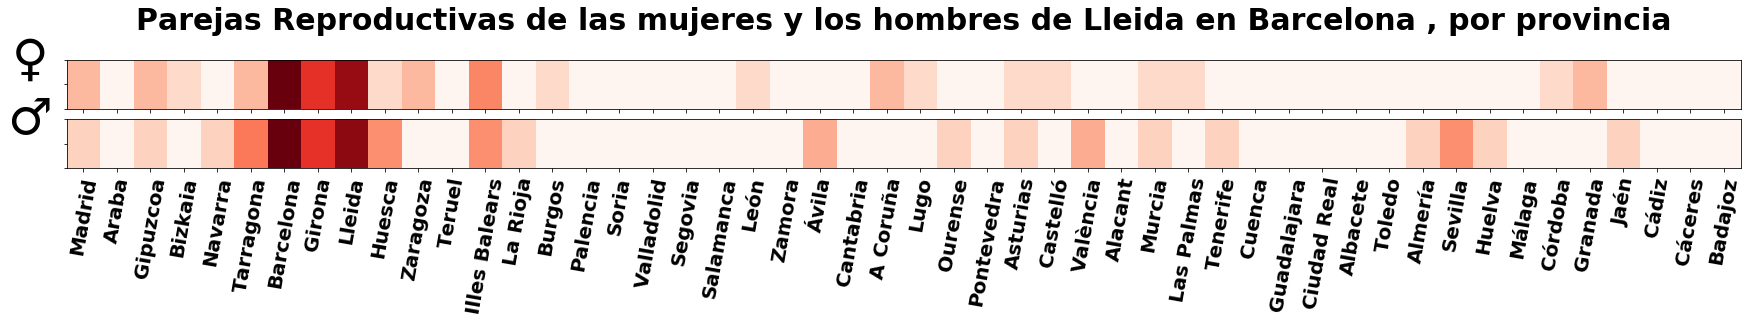

In [50]:
plot_sexos_prov('Lleida', en = 'Barcelona')

#### de Ourense

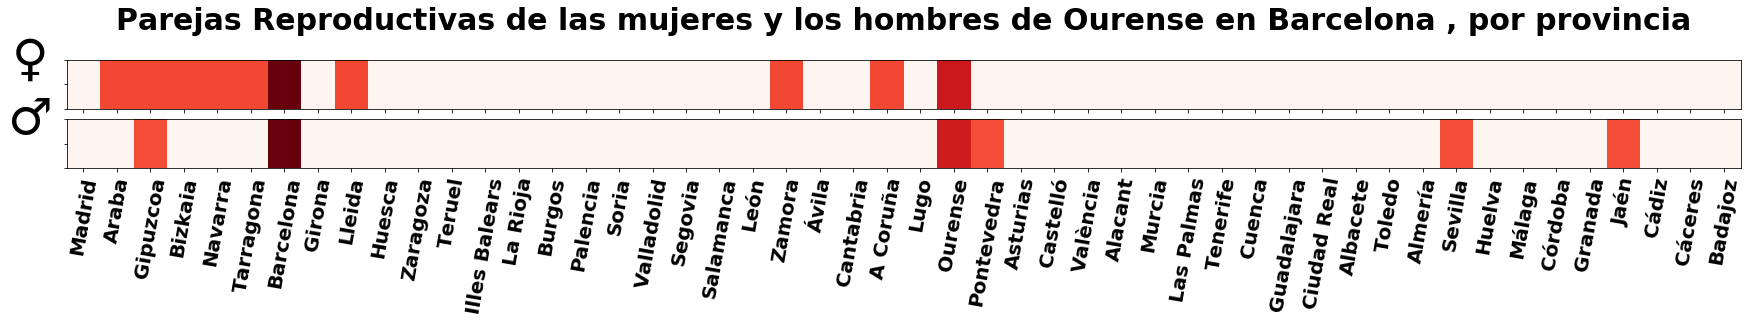

In [51]:
plot_sexos_prov('Ourense', en = 'Barcelona')

#### de Sevilla

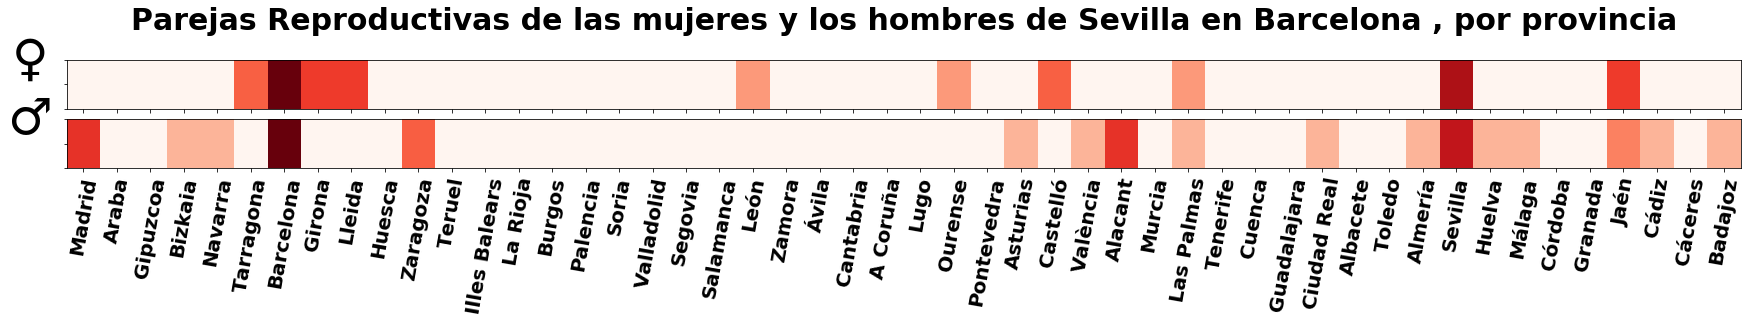

In [52]:
plot_sexos_prov('Sevilla', en = 'Barcelona')

### A Madrid

In [53]:
matrices_madrid = get_matrices('Madrid')
matrices_pareja_normal = get_matrices_pareja_normal(matrices_madrid)
matrices_padre_normal = get_matrices_padre_normal(matrices_madrid)
matrices_madre_normal = get_matrices_madre_normal(matrices_madrid)

#### de Toledo

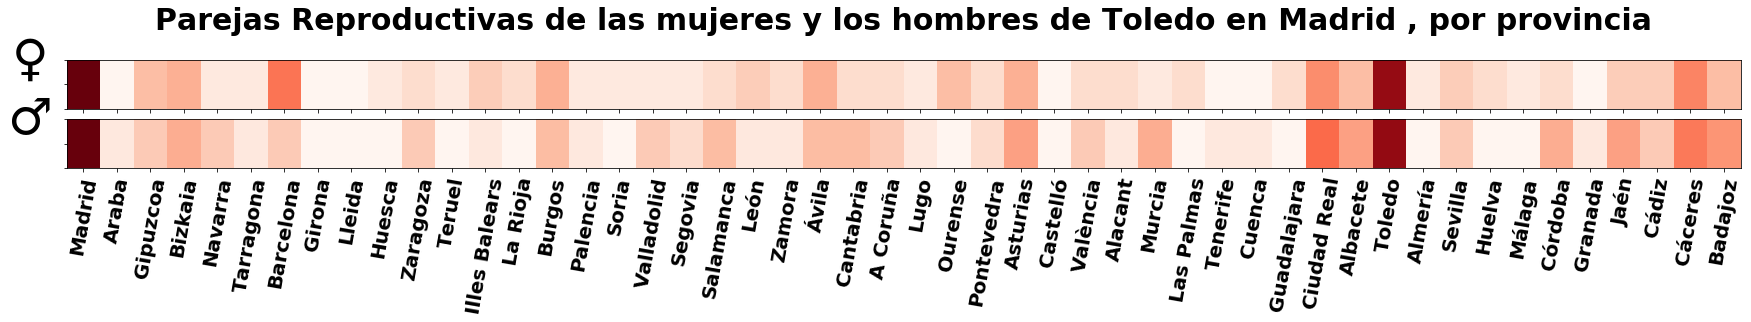

In [54]:
plot_sexos_prov('Toledo', en = 'Madrid')

#### de Ourense

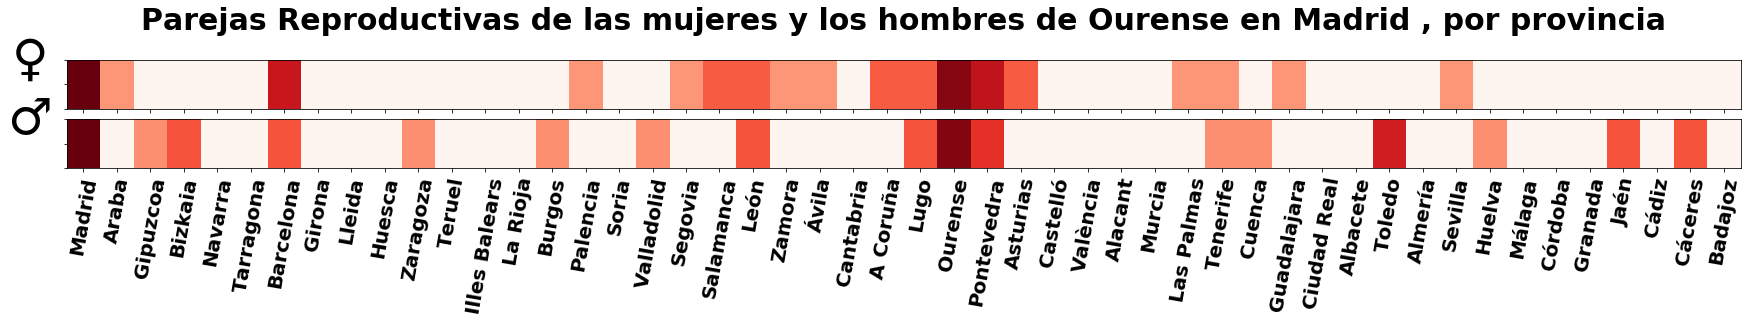

In [55]:
plot_sexos_prov('Ourense', en = 'Madrid')

#### de Sevilla

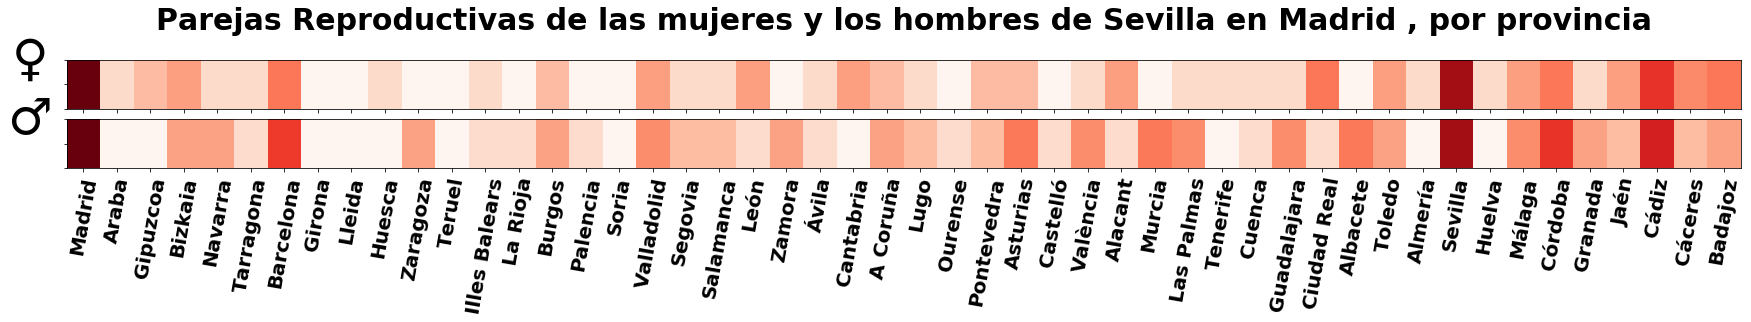

In [56]:
plot_sexos_prov('Sevilla', en = 'Madrid')

<a name="mapas"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[VII] Bonus Map</span></div>

En este último apartado, volvemos sobre las matrices normalizadas por padre y madre que usamos en el apartado V, representando sus valores para algunas provincias, mediante mapas *choropleth*

In [57]:
matrices = get_matrices()
matrices_pareja_normal = get_matrices_pareja_normal(matrices)
matrices_padre_normal = get_matrices_padre_normal(matrices)
matrices_madre_normal = get_matrices_madre_normal(matrices)

In [58]:
def mapas_interprovinciales(provincias, sl = False, tsl = 1):
    
    arg = provincias
    n = len(arg)  
    fig, ax = plt.subplots(n,2, figsize=(20, 15*n), squeeze =False)
    
    for i in range(0,n):
        
        valores = matrices_padre_normal[año].loc[[arg[i]]].transpose().sort_values([arg[i]], ascending = False)
        if sl == True:
            for time in range(0,tsl):
                valores = valores.applymap(lambda celda : math.log(max(0,celda) + 1))
        mapa = map_df.join(valores)
        mapa.loc[mapa[arg[i]].isnull(),arg[i]]  = 0
        mapa = mapa[mapa["CCAA"] != "Canarias"]

        mapa.plot(column=arg[i], cmap="OrRd", linewidth=1.8, ax = ax[i,0], edgecolor="0.6",scheme='equal_interval')
        ax[i,0].axis('off')
        ax[i,0].set_title("Con " + dict_gen_fem[arg[i]], fontdict = {'fontsize': 30,'fontweight':700}, pad =30)

        valores = matrices_madre_normal[año].transpose().loc[[arg[i]]].transpose().sort_values(arg[i],ascending=False)
        if sl == True:
            for time in range(0,tsl):
                valores = valores.applymap(lambda celda : math.log(max(0,celda) + 1))
        mapa=map_df.join(valores)
        mapa.loc[mapa[arg[i]].isnull(),arg[i]]  = 0
        mapa = mapa[mapa["CCAA"] != "Canarias"]
        
        mapa.plot(column=arg[i], cmap="OrRd", linewidth=1.8, ax = ax[i,1], edgecolor="0.6",scheme='equal_interval')
        ax[i,1].axis('off')
        ax[i,1].set_title("Con " + dict_gen_mas[arg[i]], fontdict = {'fontsize': 30,'fontweight':700}, pad =30)

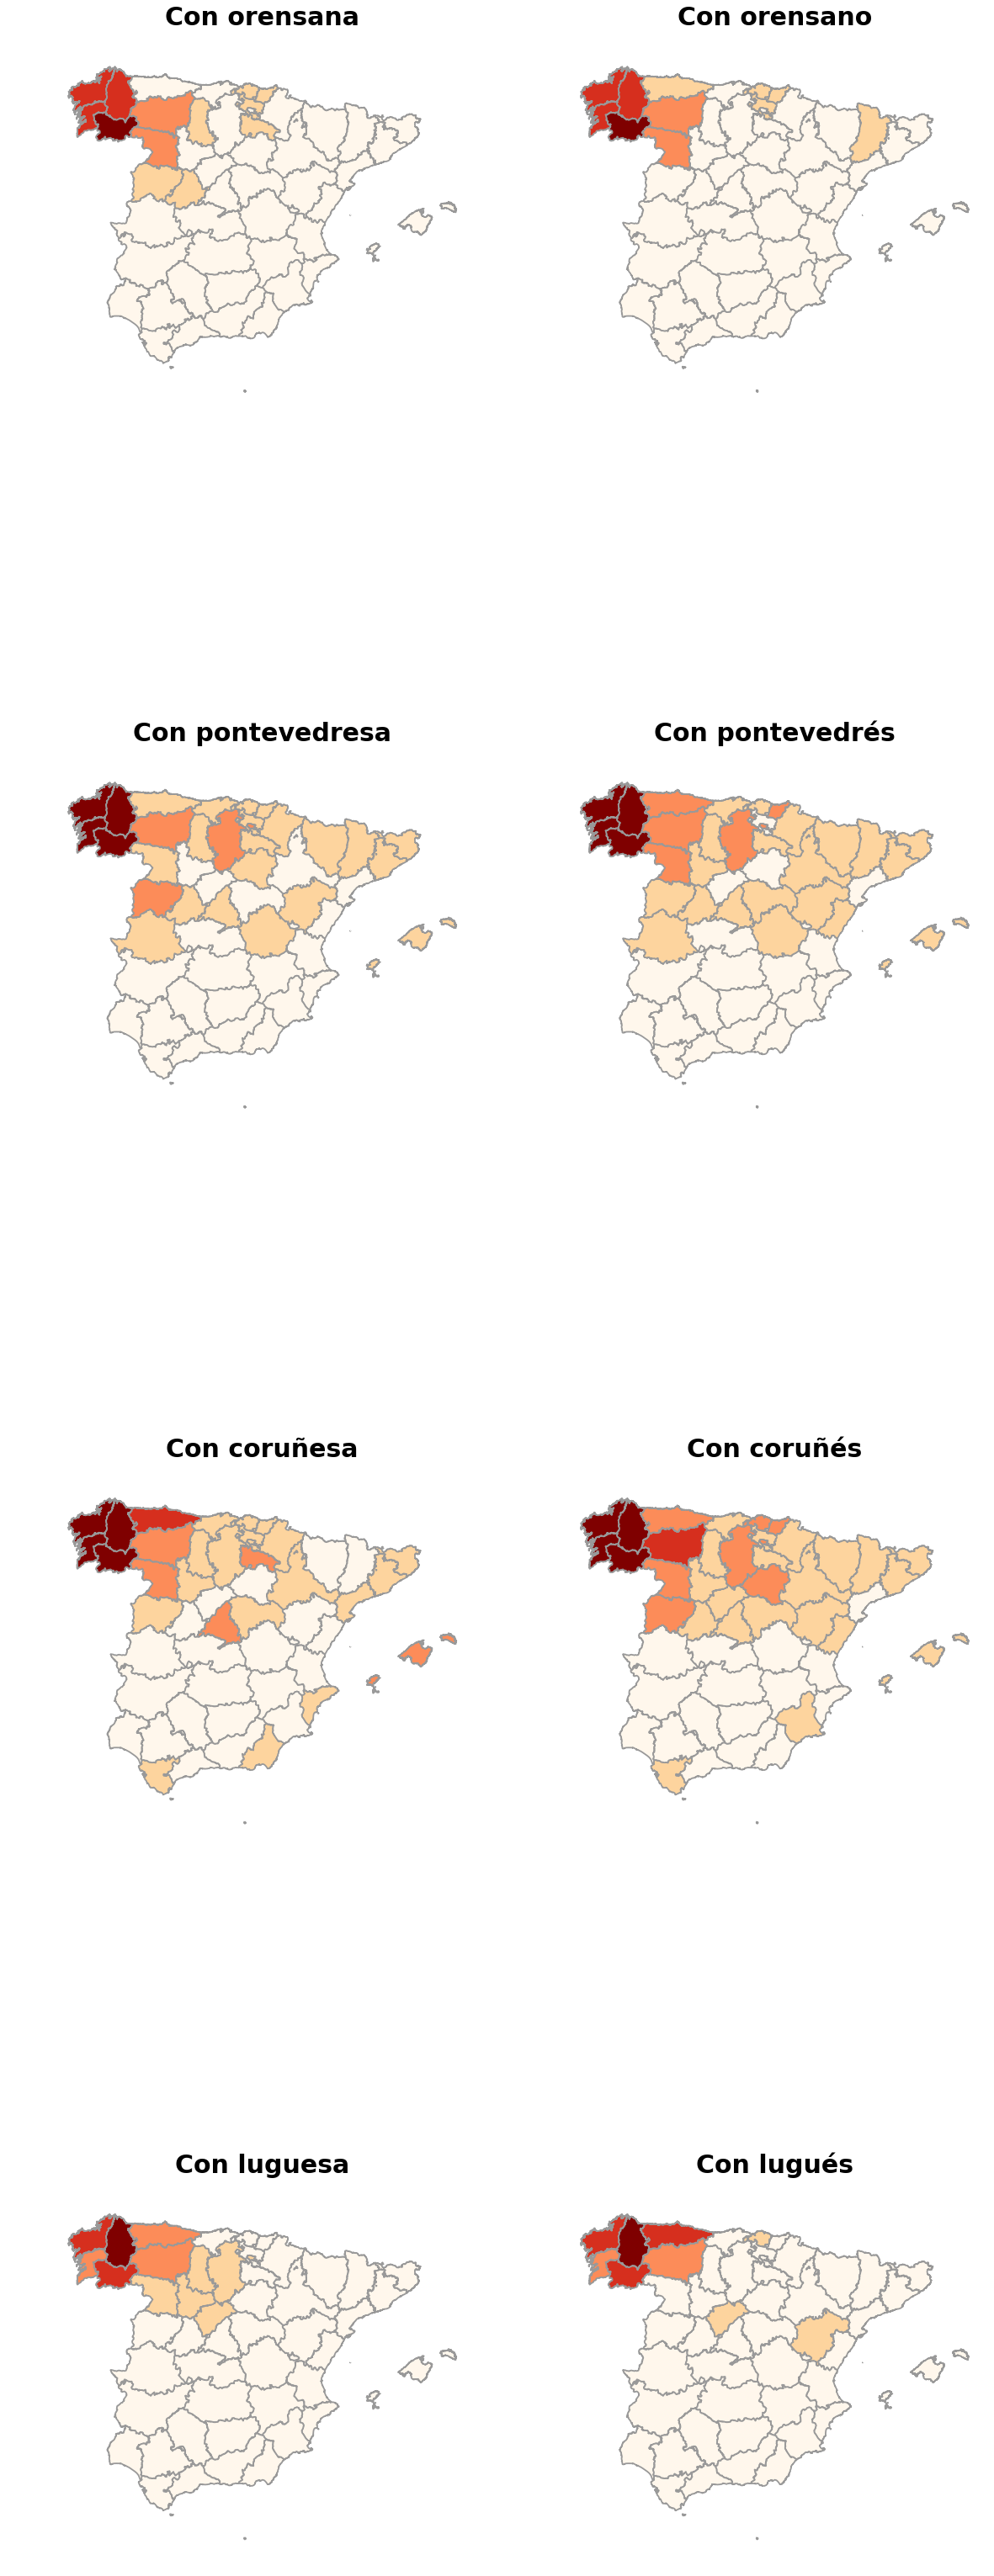

In [59]:
mapas_interprovinciales(["Ourense","Pontevedra","A Coruña","Lugo"],True,200)

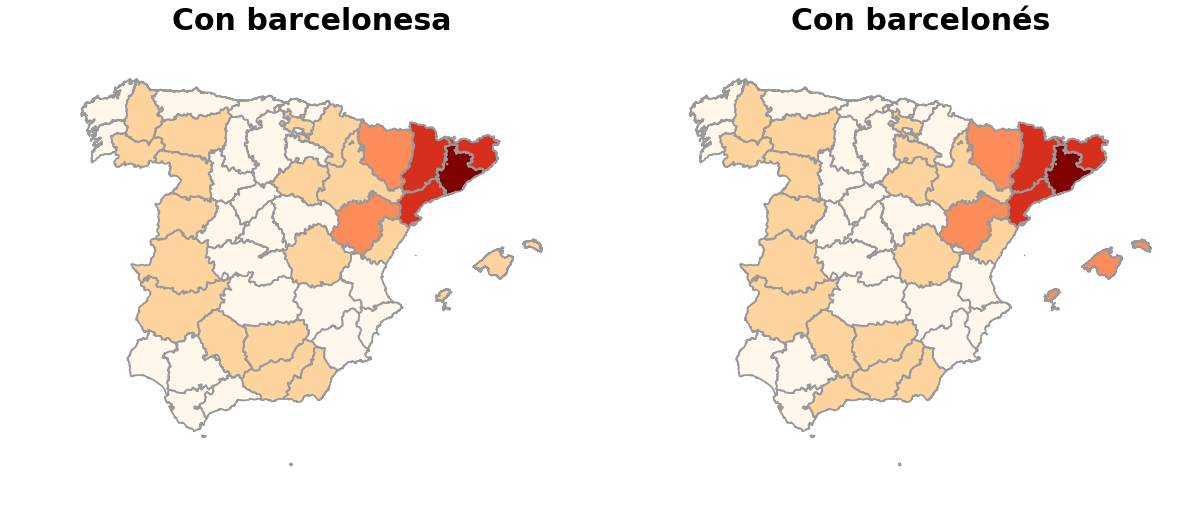

In [70]:
mapas_interprovinciales(['Barcelona'],True,20)

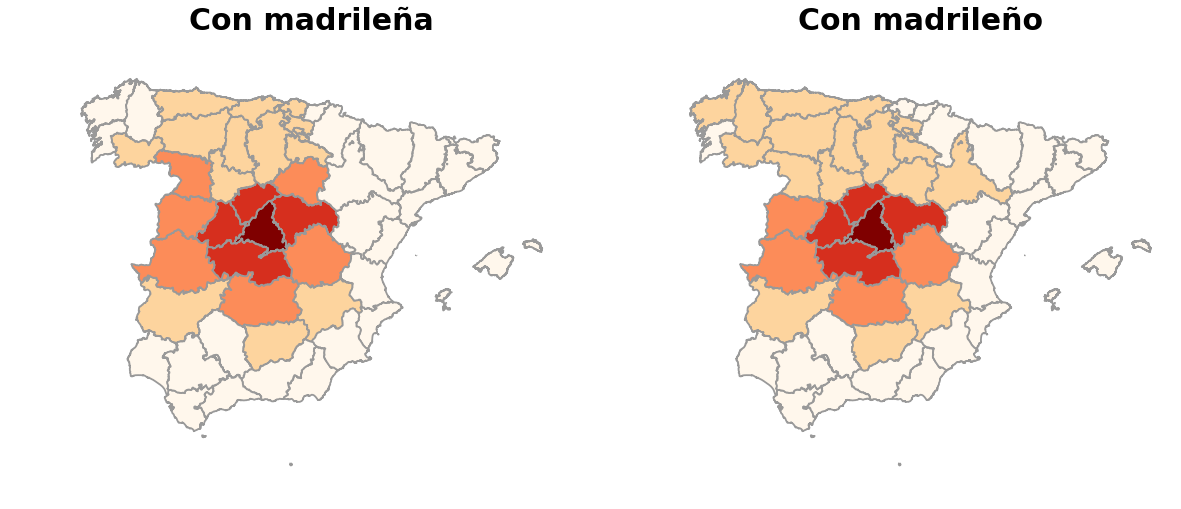

In [72]:
mapas_interprovinciales(['Madrid'],True,10)


##  <a href="../index.html#relaciones_interprovinciales_en_espanha" style="color:grey;text-decoration: none"> &lt; &lt; Volver al Índice